<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/CVAE_MNIST_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys

#### Import Data (and select part of it only)

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def pick_class(x_train, y_train, class_n):
  pics = (y_train == class_n[0])
  for i in range(len(class_n)-1):
    pics = pics + (y_train == class_n[i+1])
  new_x_train=x_train[pics]
  new_y_train=y_train[pics]
  return new_x_train, new_y_train

classes_to_train = [8]
x_train, y_train = pick_class(x_train, y_train, classes_to_train)

data_input = -1
x_train = x_train[0:data_input]
y_train = y_train[0:data_input]

#### Define Data Size and Classes

In [0]:
# INPUT DATA
class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1

N_train = len(y_train)
N_test = len(y_test)
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

#### Plot images from set (random or in order)

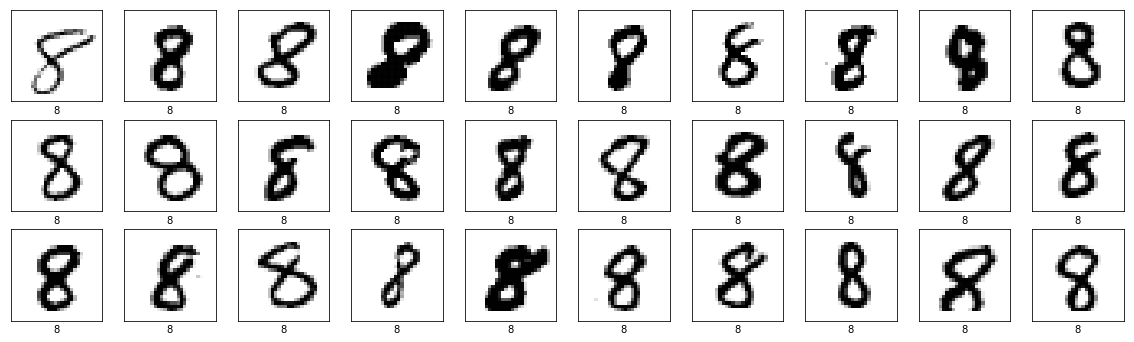

In [1031]:
def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

plot_images(x_train, y_train, [160,190])

#### Pre-Proces Data

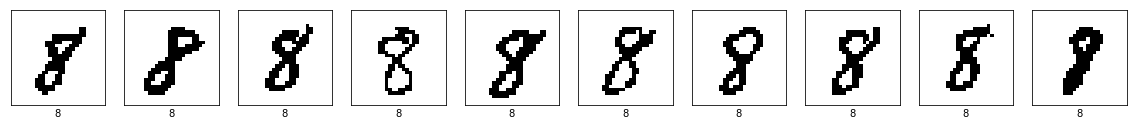

In [1032]:
train_images = x_train/input_range
test_images = x_test/input_range

def set_pixels_binary(images):
    images[images >= 0.5] = 1.0
    images[images < 0.5] = 0.0
    return images

train_images = set_pixels_binary(train_images)
test_images = set_pixels_binary(test_images)
train_labels = y_train
test_labels = y_test

plot_images(train_images, train_labels, [0,10])

train_images = train_images.reshape(N_train, image_shape[0], image_shape[1], N_image_channels).astype('float32')
test_images = test_images.reshape(N_test, image_shape[0], image_shape[1], N_image_channels).astype('float32')

#### Create Dataset

In [0]:
batch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(N_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(N_test).batch(batch_size)

#### Create Variational Autoencoder (VAE) Model

In [1034]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])
    @tf.function
    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      
    @tf.function
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

z_size = 10
model = CVAE(z_size)
model.encoder_nn.summary()
model.decoder_nn.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
flatten_19 (Flatten)         (None, 36864)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 20)                737300    
Total params: 756,116
Trainable params: 756,116
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 36864)             405504    
________________________

#### Define the loss function 

In [0]:
@tf.function
def calculate_ELBO(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO #Negative because we want to maximise it

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

@tf.function
def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

#### Train the data

Epoch 1 progress (%): 1.694915254237288INFO:tensorflow:Converted call: <function train_step at 0x7fa235357158>
    args: (<__main__.CVAE object at 0x7fa2328e6fd0>, <tf.Tensor 'x:0' shape=(100, 28, 28, 1) dtype=float32>, <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fa23795e7f0>)
    kwargs: {}

INFO:tensorflow:Entity <function train_step at 0x7fa235357158> is not cached for key <code object train_step at 0x7fa235542270, file "<ipython-input-1038-4e14b7fb1593>", line 1> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7fa2351edd30>, frozenset())
INFO:tensorflow:Converting <function train_step at 0x7fa235357158>
INFO:tensorflow:Compiled output of <function train_step at 0x7fa235357158>:

# coding=utf-8
def tf__train_step(model, x, optimizer):
  with ag__.FunctionScope('train_step', 'train_step_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as train_step_scope:
    

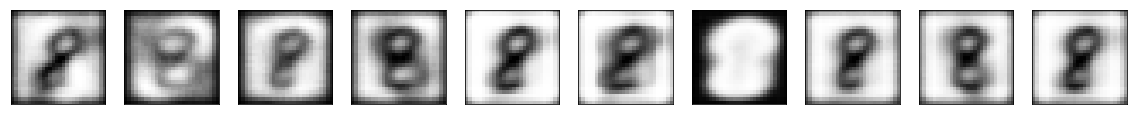

Epoch 2 progress (%): 100.0
Train ELBO: -215.9330596923828;
Test ELBO: -211.34979248046875;
Generated images:


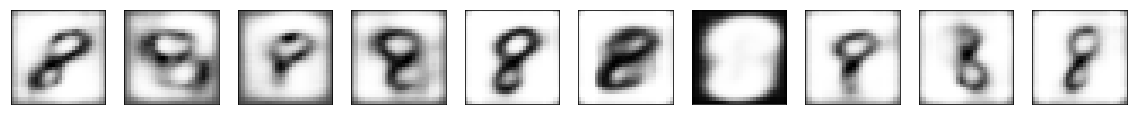

Epoch 3 progress (%): 100.0
Train ELBO: -189.567626953125;
Test ELBO: -199.9481201171875;
Generated images:


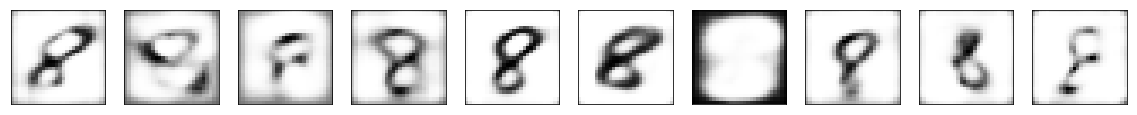

Epoch 4 progress (%): 100.0
Train ELBO: -171.37649536132812;
Test ELBO: -192.1260223388672;
Generated images:


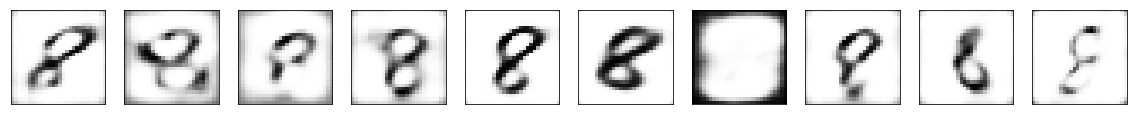

Epoch 5 progress (%): 100.0
Train ELBO: -158.68975830078125;
Test ELBO: -186.9236602783203;
Generated images:


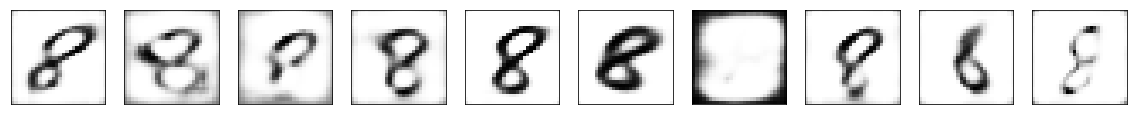

Epoch 6 progress (%): 100.0
Train ELBO: -149.5051727294922;
Test ELBO: -183.0872344970703;
Generated images:


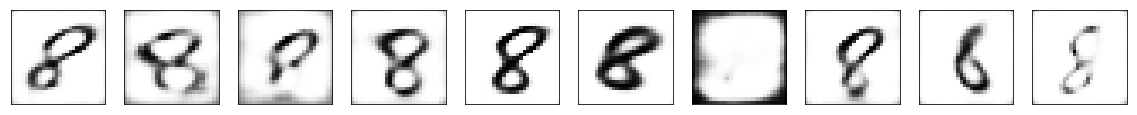

Epoch 7 progress (%): 100.0
Train ELBO: -142.52304077148438;
Test ELBO: -180.43069458007812;
Generated images:


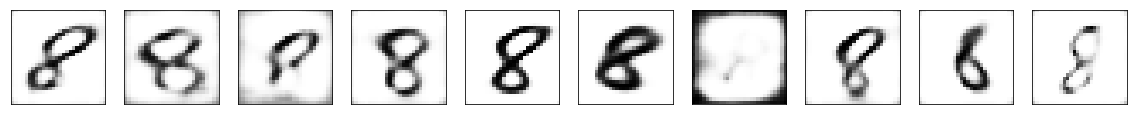

Epoch 8 progress (%): 100.0
Train ELBO: -137.02542114257812;
Test ELBO: -178.8497314453125;
Generated images:


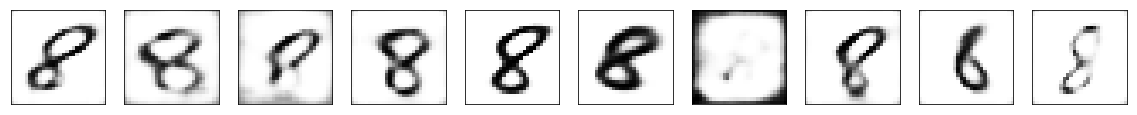

Epoch 9 progress (%): 100.0
Train ELBO: -132.55215454101562;
Test ELBO: -177.5334930419922;
Generated images:


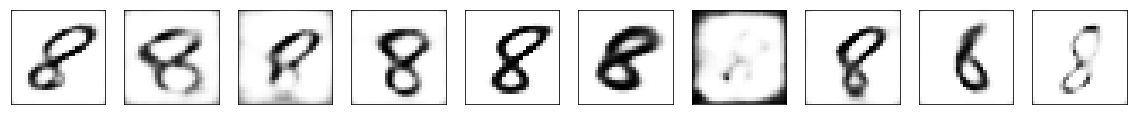

Epoch 10 progress (%): 100.0
Train ELBO: -128.82716369628906;
Test ELBO: -176.52052307128906;
Generated images:


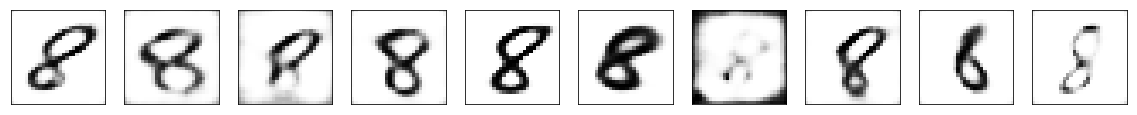

Epoch 11 progress (%): 100.0
Train ELBO: -125.66899871826172;
Test ELBO: -176.11138916015625;
Generated images:


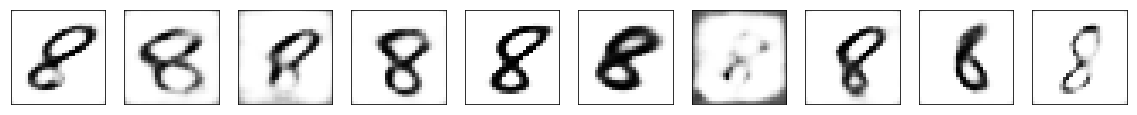

Epoch 12 progress (%): 100.0
Train ELBO: -122.9505615234375;
Test ELBO: -175.7120361328125;
Generated images:


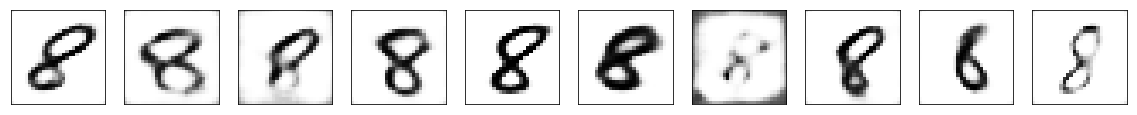

Epoch 13 progress (%): 100.0
Train ELBO: -120.54802703857422;
Test ELBO: -175.41650390625;
Generated images:


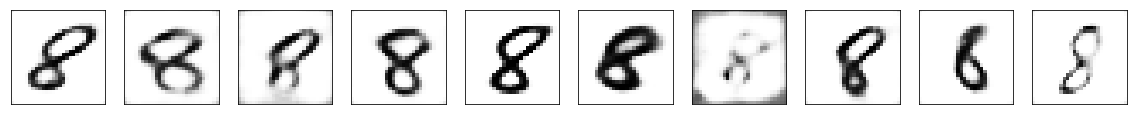

Epoch 14 progress (%): 100.0
Train ELBO: -118.41394805908203;
Test ELBO: -175.11517333984375;
Generated images:


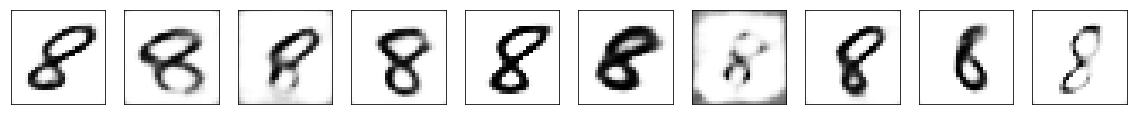

Epoch 15 progress (%): 100.0
Train ELBO: -116.50472259521484;
Test ELBO: -175.08370971679688;
Generated images:


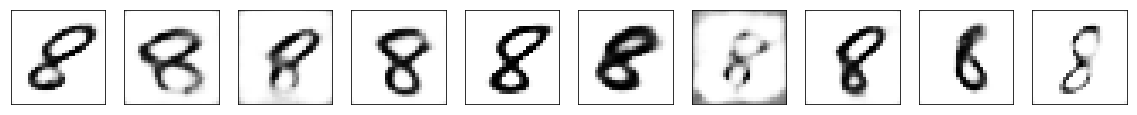

Epoch 16 progress (%): 100.0
Train ELBO: -114.78697204589844;
Test ELBO: -175.0615997314453;
Generated images:


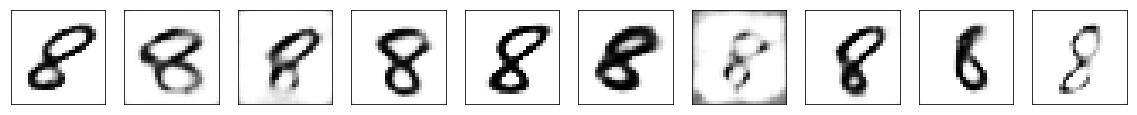

Epoch 17 progress (%): 100.0
Train ELBO: -113.23129272460938;
Test ELBO: -175.16900634765625;
Generated images:


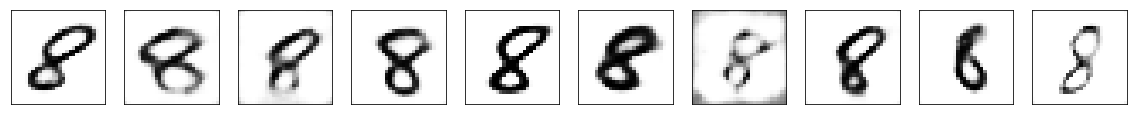

Epoch 18 progress (%): 100.0
Train ELBO: -111.80499267578125;
Test ELBO: -175.30667114257812;
Generated images:


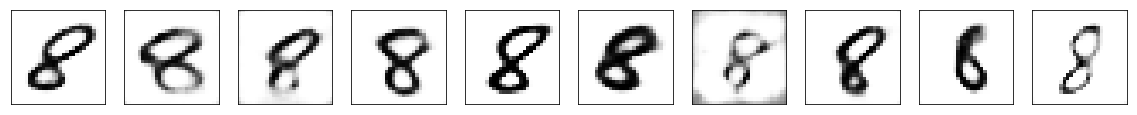

Epoch 19 progress (%): 100.0
Train ELBO: -110.49227905273438;
Test ELBO: -175.46322631835938;
Generated images:


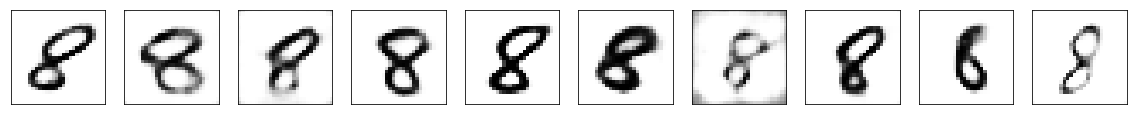

Epoch 20 progress (%): 100.0
Train ELBO: -109.27837371826172;
Test ELBO: -175.7104034423828;
Generated images:


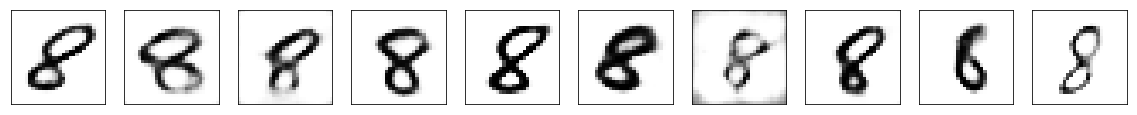

Epoch 21 progress (%): 100.0
Train ELBO: -108.1466293334961;
Test ELBO: -175.9059295654297;
Generated images:


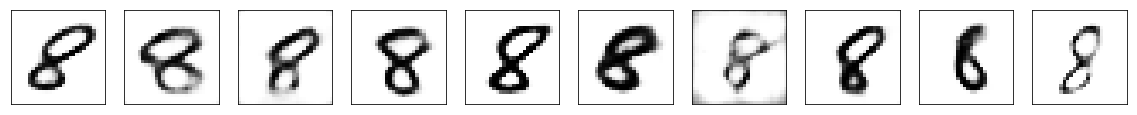

Epoch 22 progress (%): 100.0
Train ELBO: -107.07377624511719;
Test ELBO: -176.22796630859375;
Generated images:


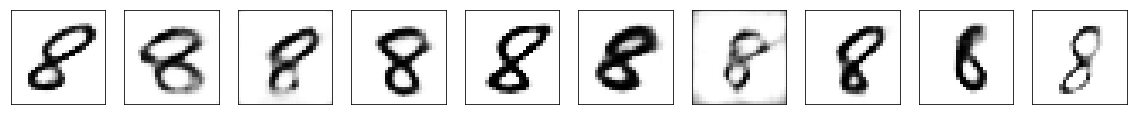

Epoch 23 progress (%): 100.0
Train ELBO: -106.08131408691406;
Test ELBO: -176.58932495117188;
Generated images:


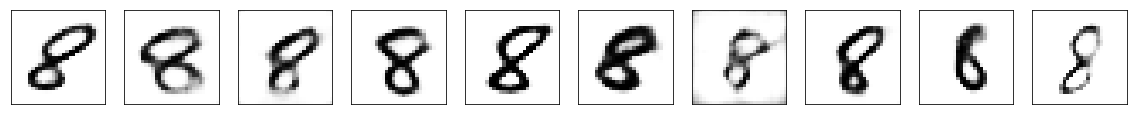

Epoch 24 progress (%): 100.0
Train ELBO: -105.14823913574219;
Test ELBO: -177.04986572265625;
Generated images:


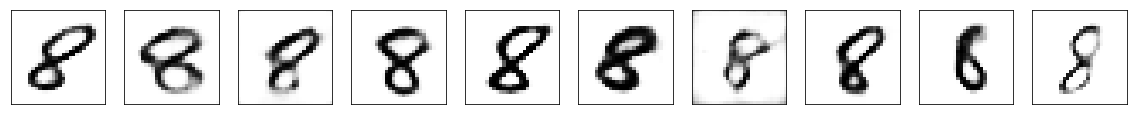

Epoch 25 progress (%): 100.0
Train ELBO: -104.2647476196289;
Test ELBO: -177.45187377929688;
Generated images:


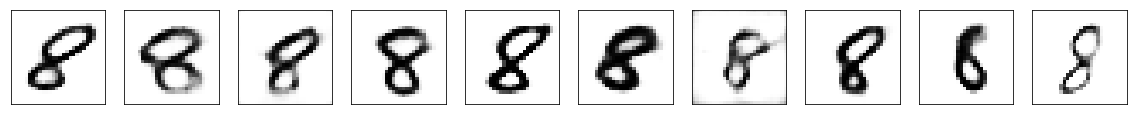

Epoch 26 progress (%): 100.0
Train ELBO: -103.4296646118164;
Test ELBO: -177.87156677246094;
Generated images:


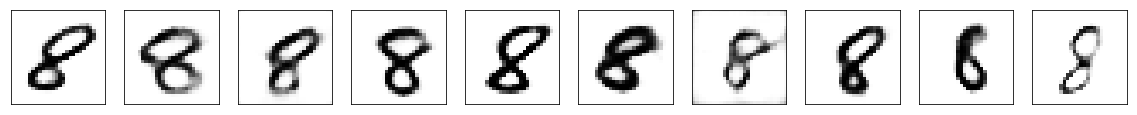

Epoch 27 progress (%): 100.0
Train ELBO: -102.63538360595703;
Test ELBO: -178.38023376464844;
Generated images:


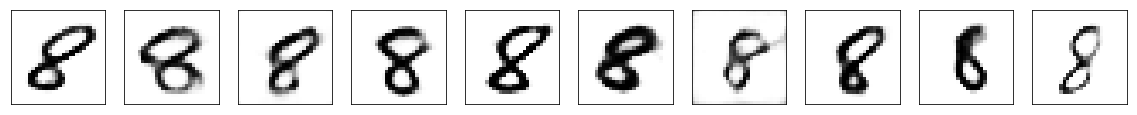

Epoch 28 progress (%): 100.0
Train ELBO: -101.87837982177734;
Test ELBO: -178.85525512695312;
Generated images:


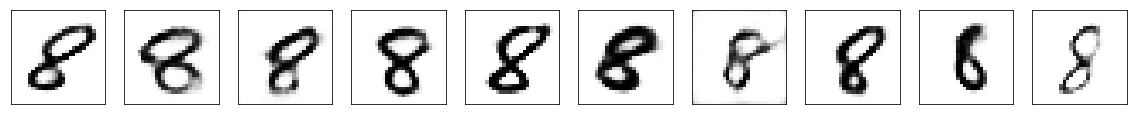

Epoch 29 progress (%): 100.0
Train ELBO: -101.1591567993164;
Test ELBO: -179.30960083007812;
Generated images:


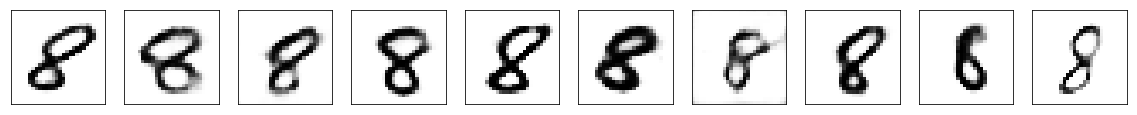

Epoch 30 progress (%): 100.0
Train ELBO: -100.46857452392578;
Test ELBO: -179.92257690429688;
Generated images:


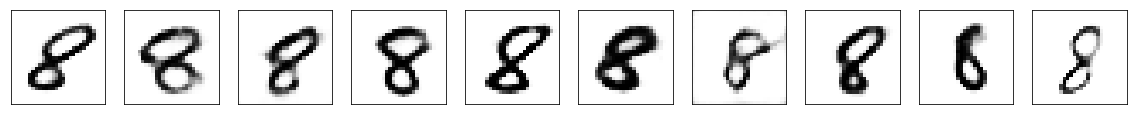

Epoch 31 progress (%): 100.0
Train ELBO: -99.80723571777344;
Test ELBO: -180.43594360351562;
Generated images:


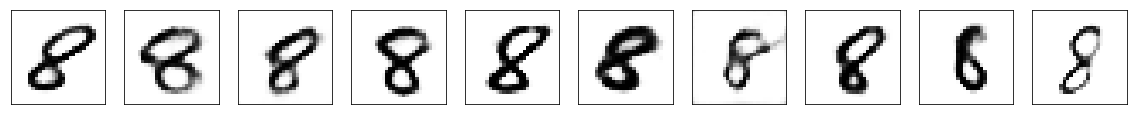

Epoch 32 progress (%): 100.0
Train ELBO: -99.17530822753906;
Test ELBO: -180.92396545410156;
Generated images:


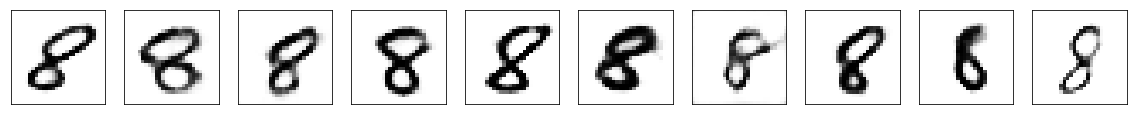

Epoch 33 progress (%): 100.0
Train ELBO: -98.57410430908203;
Test ELBO: -181.47509765625;
Generated images:


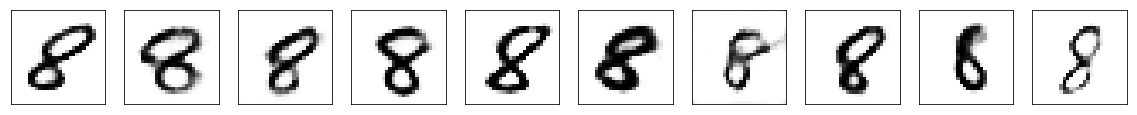

Epoch 34 progress (%): 100.0
Train ELBO: -97.99201202392578;
Test ELBO: -182.03604125976562;
Generated images:


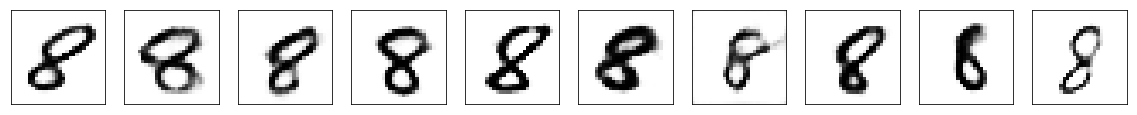

Epoch 35 progress (%): 100.0
Train ELBO: -97.43218994140625;
Test ELBO: -182.5624237060547;
Generated images:


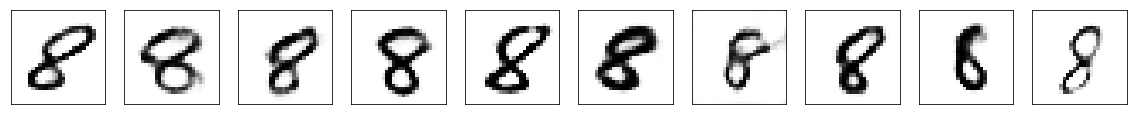

Epoch 36 progress (%): 100.0
Train ELBO: -96.89735412597656;
Test ELBO: -183.11770629882812;
Generated images:


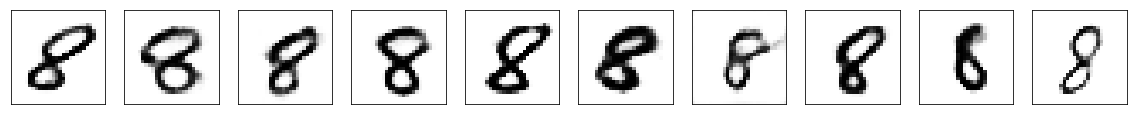

Epoch 37 progress (%): 100.0
Train ELBO: -96.37361907958984;
Test ELBO: -183.74020385742188;
Generated images:


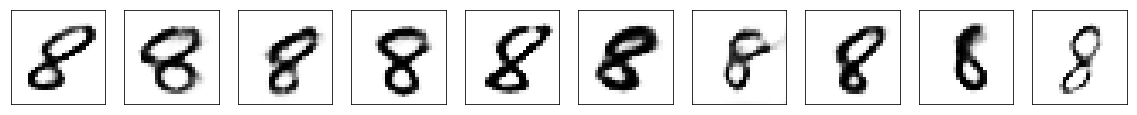

Epoch 38 progress (%): 100.0
Train ELBO: -95.86617279052734;
Test ELBO: -184.36753845214844;
Generated images:


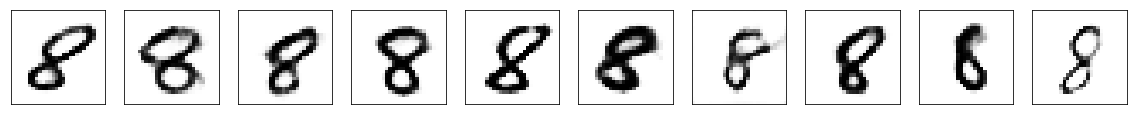

Epoch 39 progress (%): 100.0
Train ELBO: -95.38084411621094;
Test ELBO: -184.9539031982422;
Generated images:


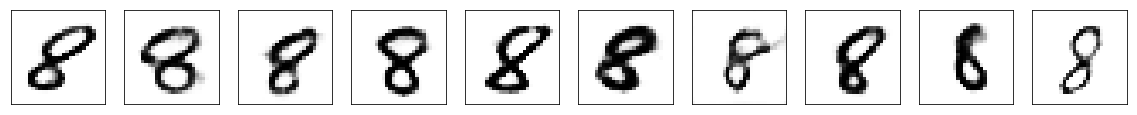

Epoch 40 progress (%): 100.0
Train ELBO: -94.90853118896484;
Test ELBO: -185.59066772460938;
Generated images:


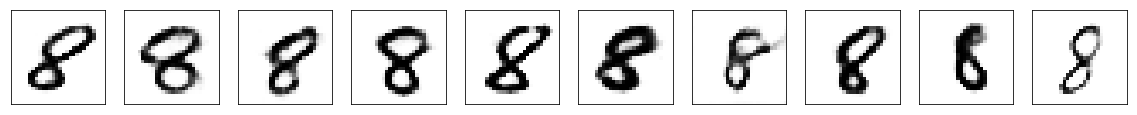

In [1041]:
epochs = 40
plots_per_epoch = 10
z_random = tf.random.normal(shape=[plots_per_epoch, z_size])

for epoch in range(epochs):
    for i, train_x in enumerate(train_dataset): 
        sys.stdout.write('\r'+'Epoch {} progress (%): {}'.format(epoch+1,100*(i+1)/(np.ceil(N_train/batch_size))))
        sys.stdout.flush()
        train_step(model, train_x, optimizer)

    for i, test_x in enumerate(test_dataset):
        test_step(model, test_x, optimizer)
    
    print('\nTrain ELBO: {};\nTest ELBO: {};\nGenerated images:'.format(-train_loss.result(), -test_loss.result()))
    
    generate_images(model, z_random, [0,plots_per_epoch])

#### Reconstruct images

In [0]:
def reconstruct_images(images, images_to_reconstruct):
    images_to_pick = len(images)
    y = images
    x = images_to_reconstruct
    loss = np.empty([images_to_pick])

    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    for i in range(images_to_pick):
        loss[i] = calculate_ELBO(model,x[i:i+1])

    loss = loss.astype('float16')
    print('Original Pictures:')
    plot_images(y, _, figures_to_plot=[0,images_to_pick], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_to_pick], include_labels=True)

reconstruct_images(x_test[0:10],test_images[0:10])


#### Visualize the latent space

In [0]:
def visualize_latent_space(range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    z_mean, z_logvar = model.encode(pic_visualize)
    if any(z_logvar[:,i]>5 for i in range(10)):
      outliers +=1
      continue
    z = model.reparameterize(z_mean, z_logvar)
    if data_y[i] == 0:
      color = 'blue'
    if data_y[i] == 1:
      color = 'orange'
    if data_y[i] == 2:
      color = 'green'
    if data_y[i] == 3:
      color = 'red'
    if data_y[i] == 4:
      color = 'purple'  
    if data_y[i] == 5:
      color = 'brown'
    if data_y[i] == 6:
      color = 'pink'
    if data_y[i] == 7:
      color = 'gray'
    if data_y[i] == 8:
      color = 'black'
    if data_y[i] == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
    #plt.xlim([-1000,1000])
    #plt.ylim([-1000,1000])
    #plt.annotate('{}'.format(i),(z[:,a],z[:,b]))
  print('{} Outliers detected'.format(outliers))


#visualize_latent_space(0,800,1,4)

#labels = []; 
#for i in range(N_train): labels.append(i)
#plot_images(x_train, labels, [250,300])
  

#### Check reconstruction performance for untrained classes


In [0]:
print('Classes trained {}'.format(classes_to_train))
for i in range(N_class):
  test_images_class = test_images[(test_labels==i)]
  loss = -calculate_ELBO(model,test_images_class)
  print('ELBO loss for class {}: {}'.format(i,loss))
  

#reconstruct_images(x_test[(y_test==8)][0:10], test_images[(y_test==8)][0:10])

visualize_latent_space(0,1000, x_train, y_train, 0,1)
classes_to_pick = [1]
x_reconstruct_test, y_reconstruct_test = pick_class(x_test, y_test, classes_to_pick)
visualize_latent_space(0,100, x_reconstruct_test, y_reconstruct_test, 0,1)
